
# Access Point Clustering with Flower Pollination Optimization
We cluster Wi-Fi access points using the multi-file telemetry dataset (client load, CPU, memory, and 2.4/5 GHz signal). The clustering objective is optimized with a **Flower Pollination Algorithm (FPA)** rather than an off-the-shelf machine-learning library.



## Setup
Only numpy/pandas/matplotlib are used; the clustering and optimization loop are implemented from scratch.


In [1]:

import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (8, 5)
plt.rcParams["axes.grid"] = True



## Load access point metrics
Each CSV is time-stamped at 5-minute resolution. We aggregate per access point later.


In [2]:

paths = {
    "client": "dataset/data 3 access point/client_metrics_uap_5min.csv.gz",
    "cpu": "dataset/data 3 access point/cpu_metrics_uap_5min.csv.gz",
    "mem": "dataset/data 3 access point/memory_metrics_uap_5min.csv.gz",
    "sig24": "dataset/data 3 access point/signal_24g_metrics_uap_5min.csv.gz",
    "sig5": "dataset/data 3 access point/signal_5g_metrics_uap_5min.csv.gz",
}

dfs = {name: pd.read_csv(path) for name, path in paths.items()}
for name, df in dfs.items():
    print(f"{name}: {df.shape[0]:,} rows, {df.shape[1]} columns")

dfs["client"].head()


client: 1,669,364 rows, 3 columns
cpu: 1,686,583 rows, 3 columns
mem: 1,669,352 rows, 3 columns
sig24: 317,103 rows, 3 columns
sig5: 576,388 rows, 3 columns


,ap_name,timestamp,client_count
0,01_29SB-RDPROD,2025-07-26 09:50:00+00:00,0
1,01_29SB-RDPROD,2025-07-26 09:55:00+00:00,0
2,01_29SB-RDPROD,2025-07-26 10:00:00+00:00,0
3,01_29SB-RDPROD,2025-07-26 10:05:00+00:00,0
4,01_29SB-RDPROD,2025-07-26 10:10:00+00:00,0



## Feature engineering (per AP)
We summarize each access point with load and signal descriptors to make clustering meaningful:
- Clients: mean, max, variability (std)
- CPU/Memory: mean and peak utilization ratios
- RF signal: mean/min/max on both 2.4 GHz and 5 GHz


In [3]:

client_agg = dfs["client"].groupby("ap_name")["client_count"].agg(["mean", "max", "std"])
client_agg["std"] = client_agg["std"].fillna(0)

cpu_agg = dfs["cpu"].groupby("ap_name")["cpu_usage_ratio"].agg(["mean", "max"])
mem_agg = dfs["mem"].groupby("ap_name")["memory_usage_ratio"].agg(["mean", "max"])
sig24_agg = dfs["sig24"].groupby("ap_name")["signal_dbm"].agg(["mean", "min", "max"])
sig5_agg = dfs["sig5"].groupby("ap_name")["signal_dbm"].agg(["mean", "min", "max"])

features = pd.concat([
    client_agg.add_prefix("clients_"),
    cpu_agg.add_prefix("cpu_"),
    mem_agg.add_prefix("mem_"),
    sig24_agg.add_prefix("sig24_"),
    sig5_agg.add_prefix("sig5_"),
], axis=1).dropna()

print(f"Access points with complete metrics: {features.shape[0]} | feature dims: {features.shape[1]}")
features.head()


Access points with complete metrics: 101 | feature dims: 13


,clients_mean,clients_max,clients_std,cpu_mean,cpu_max,mem_mean,mem_max,sig24_mean,sig24_min,sig24_max,sig5_mean,sig5_min,sig5_max
ap_name,,,,,,,,,,,,,
12SB BAWAH,0.805694,9.0,1.620498,0.030869,0.2300,0.418308,0.4280,-60.507200,-89.0,-41.0,-61.210994,-89.0,-42.0
12SB-LT1-VP,0.879065,14.0,1.402322,0.030218,0.2336,0.428925,0.4360,-59.711436,-91.0,-41.0,-56.901051,-85.0,-49.0
12SB-LT2:eaca,2.570767,20.0,4.821669,0.044099,0.2794,0.434618,0.4596,-55.172662,-85.0,-37.0,-54.733630,-79.0,-32.0
29SB-LT1-GM-PEMEL,2.168615,18.0,2.450088,0.045288,0.3390,0.458191,0.4768,-62.617238,-90.0,-40.0,-69.378552,-86.0,-46.0
29SB-LT1-RENDALPROD-PRS,5.255873,26.0,6.152078,0.098390,0.8374,0.522363,0.5584,-57.300916,-92.0,-41.0,-58.580995,-89.0,-44.0



## Preprocessing
We standardize features (z-score) to balance scale, and keep AP names for reporting. A light PCA helper is added for 2D visualization without external ML libs.


In [4]:

ap_names = features.index.to_numpy()
X = features.values.astype(float)
mean = X.mean(axis=0)
std = X.std(axis=0)
X_scaled = (X - mean) / std


def project_pca(data, n_components=2):
    # Minimal PCA via SVD for visualization only.
    centered = data - data.mean(axis=0)
    _, _, v_t = np.linalg.svd(centered, full_matrices=False)
    components = v_t[:n_components].T
    return centered @ components



## Clustering via Flower Pollination Algorithm (FPA)
We minimize within-cluster SSE by moving candidate centroids. Pollination balances global Lévy flights (exploration) with local solution mixing (exploitation).


In [5]:

# Objective: assign points to nearest centroid and compute SSE

def sse_and_labels(data, centroids):
    distances = np.linalg.norm(data[:, None, :] - centroids[None, :, :], axis=2)
    labels = np.argmin(distances, axis=1)
    sse = np.sum((data - centroids[labels]) ** 2)
    return sse, labels


# Lévy flight generator (Mantegna)

def levy_flight(beta, size, rng):
    sigma_u = (
        math.gamma(1 + beta)
        * math.sin(math.pi * beta / 2)
        / (math.gamma((1 + beta) / 2) * beta * 2 ** ((beta - 1) / 2))
    ) ** (1 / beta)
    u = rng.normal(0, sigma_u, size)
    v = rng.normal(0, 1, size)
    return u / (np.abs(v) ** (1 / beta))


def fpa_cluster(
    data,
    k=3,
    pop_size=25,
    iterations=120,
    p_global=0.85,
    beta=1.5,
    seed=42,
):
    rng = np.random.default_rng(seed)
    d = data.shape[1]
    lower, upper = data.min(axis=0), data.max(axis=0)

    def init_centroids():
        idx = rng.choice(len(data), k, replace=False)
        return data[idx]

    population = [init_centroids() for _ in range(pop_size)]
    fitness = []
    for centroids in population:
        sse, _ = sse_and_labels(data, centroids)
        fitness.append(sse)

    best_idx = int(np.argmin(fitness))
    best_centroids = population[best_idx].copy()
    best_score = fitness[best_idx]
    history = [best_score]

    for _ in range(iterations):
        for i in range(pop_size):
            if rng.random() < p_global:
                step = levy_flight(beta, d, rng)
                proposal = population[i] + step * (population[i] - best_centroids)
            else:
                j, k_idx = rng.choice(pop_size, 2, replace=False)
                epsilon = rng.random()
                proposal = population[i] + epsilon * (population[j] - population[k_idx])

            proposal = np.clip(proposal, lower, upper)
            sse, _ = sse_and_labels(data, proposal)
            if sse < fitness[i]:
                population[i] = proposal
                fitness[i] = sse
            if sse < best_score:
                best_score = sse
                best_centroids = proposal.copy()
        history.append(best_score)

    final_sse, labels = sse_and_labels(data, best_centroids)
    return best_centroids, labels, history, final_sse



## Run optimization


In [6]:

k = 3
best_centroids, labels, history, final_sse = fpa_cluster(X_scaled, k=k)
cluster_sizes = np.bincount(labels, minlength=k)
print(f"Final SSE: {final_sse:.2f} | Initial SSE: {history[0]:.2f}")
print("Cluster sizes:", cluster_sizes)


Final SSE: 1094.77 | Initial SSE: 1205.04
Cluster sizes: [75 16 10]



## Quality check (silhouette) and cluster summaries
Silhouette is computed manually (no sklearn) to gauge separation. Cluster-level stats are reported in original units.


In [7]:

# Manual silhouette score
pairwise = np.linalg.norm(X_scaled[:, None, :] - X_scaled[None, :, :], axis=2)
unique_labels = np.unique(labels)
silhouettes = []
for i in range(len(X_scaled)):
    same = labels == labels[i]
    a = pairwise[i, same].mean() if same.sum() > 1 else 0
    b = min(pairwise[i, labels == c].mean() for c in unique_labels if c != labels[i])
    silhouettes.append((b - a) / max(a, b) if max(a, b) > 0 else 0)

silhouette_score = float(np.mean(silhouettes))
print(f"Silhouette (manual): {silhouette_score:.3f}")

centroids_unscaled = best_centroids * std + mean

summary_rows = []
for c in range(k):
    mask = labels == c
    cluster_df = features.iloc[mask]
    summary_rows.append(
        {
            "cluster": c,
            "size": int(mask.sum()),
            "clients_mean": cluster_df["clients_mean"].mean(),
            "clients_max": cluster_df["clients_max"].mean(),
            "cpu_mean": cluster_df["cpu_mean"].mean(),
            "mem_mean": cluster_df["mem_mean"].mean(),
            "sig24_mean": cluster_df["sig24_mean"].mean(),
            "sig5_mean": cluster_df["sig5_mean"].mean(),
        }
    )

summary_df = pd.DataFrame(summary_rows).sort_values("size", ascending=False)
summary_df


Silhouette (manual): 0.200


,cluster,size,clients_mean,clients_max,cpu_mean,mem_mean,sig24_mean,sig5_mean
0,0,75,1.615328,10.240,0.044537,0.413849,-64.700609,-63.053474
1,1,16,6.731695,29.375,0.065106,0.549020,-63.065411,-56.975382
2,2,10,1.219222,7.400,0.022773,0.564263,-57.267921,-57.388859



## Visualization
Top-left: PCA projection of APs colored by cluster. Bottom-right: FPA convergence curve.


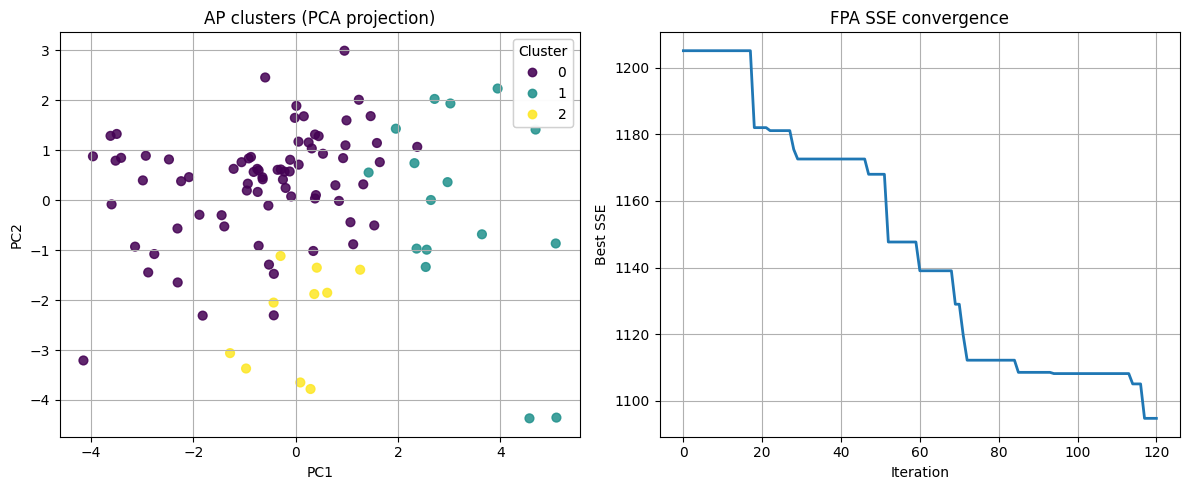

In [8]:

proj = project_pca(X_scaled, n_components=2)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
scatter = axes[0].scatter(proj[:, 0], proj[:, 1], c=labels, cmap="viridis", s=40, alpha=0.85)
axes[0].set_title("AP clusters (PCA projection)")
axes[0].set_xlabel("PC1")
axes[0].set_ylabel("PC2")
legend = axes[0].legend(*scatter.legend_elements(), title="Cluster")
axes[0].add_artist(legend)

axes[1].plot(history, lw=2)
axes[1].set_title("FPA SSE convergence")
axes[1].set_xlabel("Iteration")
axes[1].set_ylabel("Best SSE")

plt.tight_layout()
plt.show()



## Inspect APs inside each cluster
This helps explain the grouping based on utilization/signal patterns.


In [9]:

cluster_assignments = pd.DataFrame({"ap_name": ap_names, "cluster": labels})
for c in range(k):
    print(f"Cluster {c} (n={int((labels==c).sum())}) top APs:")
    print(cluster_assignments[cluster_assignments.cluster == c].head(10).ap_name.tolist())


Cluster 0 (n=75) top APs:
['12SB BAWAH', '12SB-LT1-VP', '12SB-LT2:eaca', '29SB-LT1-GM-PEMEL', '29SB-LT1-SVP-VP', '29SB-LT2-R.PAKAR', '29SB-LT2-RBPKOR', '2SB-LT1-RENDAL-PEM', '2SB-LT1-RENDAL-PEM(baru)', '2SB-LT2-GMTSI']
Cluster 1 (n=16) top APs:
['29SB-LT1-RENDALPROD-PRS', '4SB-RELIABILITY', 'BDG-PJG-L', 'BDG-PJG-R', 'BEDENG-PANJANG', 'CRUTL34-CENTRE', 'HIPERKES-LT2-LH', 'K3-LT1-R', 'LAB-KALIBRASI-PEMEL', 'OPRP4-AMONNIA']
Cluster 2 (n=10) top APs:
['BKLMESIN-LT1', 'COMMANDCENTRE', 'INSTRUMENP2B-L', 'INSTRUMENP2B-R', 'LAB-INVENTORY', 'P1B_LT2_C', 'P4-SHELTERTA', 'TELKA', 'TELKA01', 'TJSL-U6-Pro']



## Alternative: Deterministic Annealing Clustering (DAC)
To push for a stronger optimum, we add DAC: a soft-assignment clustering method that anneals a temperature term. At high temperature, assignments are diffuse (global search); as temperature cools, clusters harden, often avoiding poor local minima better than standard k-means.


In [10]:

import math


def deterministic_annealing_cluster(
    data,
    k=3,
    T0=6.0,
    Tmin=0.01,
    alpha=0.9,
    inner_steps=12,
    seed=123,
):
    rng = np.random.default_rng(seed)
    n, d = data.shape
    centroids = data[rng.choice(n, k, replace=False)].copy()
    history = []

    # Track best solution during cooling
    d2 = ((data[:, None, :] - centroids[None, :, :]) ** 2).sum(axis=2)
    labels = d2.argmin(axis=1)
    best_sse = float(np.sum(d2[np.arange(n), labels]))
    best_centroids = centroids.copy()

    T = T0
    while T > Tmin:
        for _ in range(inner_steps):
            d2 = ((data[:, None, :] - centroids[None, :, :]) ** 2).sum(axis=2)
            weights = np.exp(-d2 / max(T, 1e-8))
            weights = weights / (weights.sum(axis=1, keepdims=True) + 1e-12)
            denom = weights.sum(axis=0)[:, None] + 1e-12
            centroids = (weights.T @ data) / denom

        d2 = ((data[:, None, :] - centroids[None, :, :]) ** 2).sum(axis=2)
        labels = d2.argmin(axis=1)
        sse = float(np.sum(d2[np.arange(n), labels]))
        history.append((T, sse))
        if sse < best_sse:
            best_sse = sse
            best_centroids = centroids.copy()
        T *= alpha

    d2 = ((data[:, None, :] - best_centroids[None, :, :]) ** 2).sum(axis=2)
    labels = d2.argmin(axis=1)
    sse = float(np.sum(d2[np.arange(n), labels]))
    return best_centroids, labels, history, sse



### Run DAC and compare


In [11]:

anneal_centroids, anneal_labels, anneal_history, anneal_sse = deterministic_annealing_cluster(X_scaled, k=k)

# Manual silhouette for DAC
pairwise = np.linalg.norm(X_scaled[:, None, :] - X_scaled[None, :, :], axis=2)
unique_labels = np.unique(anneal_labels)
anneal_sils = []
for i in range(len(X_scaled)):
    same = anneal_labels == anneal_labels[i]
    a = pairwise[i, same].mean() if same.sum() > 1 else 0
    b = min(pairwise[i, anneal_labels == c].mean() for c in unique_labels if c != anneal_labels[i])
    anneal_sils.append((b - a) / max(a, b) if max(a, b) > 0 else 0)
anneal_silhouette = float(np.mean(anneal_sils))

anneal_sizes = np.bincount(anneal_labels, minlength=k)
print(f"DAC SSE: {anneal_sse:.2f} | Silhouette: {anneal_silhouette:.3f}")
print("Cluster sizes:", anneal_sizes)

anneal_summary = []
for c in range(k):
    mask = anneal_labels == c
    cluster_df = features.iloc[mask]
    anneal_summary.append(
        {
            "cluster": c,
            "size": int(mask.sum()),
            "clients_mean": cluster_df["clients_mean"].mean(),
            "clients_max": cluster_df["clients_max"].mean(),
            "cpu_mean": cluster_df["cpu_mean"].mean(),
            "mem_mean": cluster_df["mem_mean"].mean(),
            "sig24_mean": cluster_df["sig24_mean"].mean(),
            "sig5_mean": cluster_df["sig5_mean"].mean(),
        }
    )

pd.DataFrame(anneal_summary).sort_values("size", ascending=False)


DAC SSE: 922.98 | Silhouette: 0.211
Cluster sizes: [19 60 22]


,cluster,size,clients_mean,clients_max,cpu_mean,mem_mean,sig24_mean,sig5_mean
1,1,60,1.802217,10.883333,0.046108,0.438208,-60.156504,-60.472992
2,2,22,5.805653,26.954545,0.067166,0.525227,-64.140598,-58.271143
0,0,19,0.273239,3.473684,0.019240,0.400958,-74.409901,-68.640032



### DAC convergence (temperature → SSE)


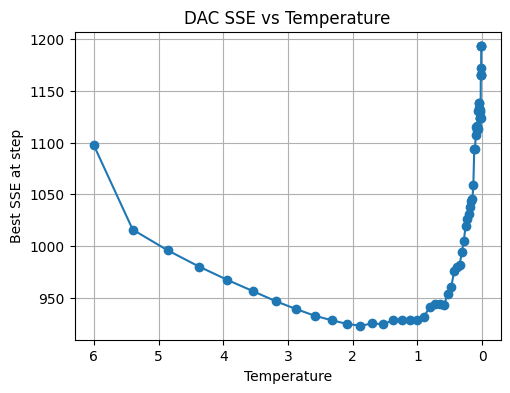

In [12]:

temps, sses = zip(*anneal_history)
plt.figure(figsize=(5.5,4))
plt.plot(temps, sses, marker="o")
plt.gca().invert_xaxis()
plt.title("DAC SSE vs Temperature")
plt.xlabel("Temperature")
plt.ylabel("Best SSE at step")
plt.show()


### Multi-start k-means++ for better separation
Search k=2..6 with many restarts; pick highest silhouette (tie-break lower SSE).


In [13]:

def manual_silhouette(data, labels):
    pairwise = np.linalg.norm(data[:, None, :] - data[None, :, :], axis=2)
    unique = np.unique(labels)
    if len(unique) == 1:
        return 0.0
    silhouettes = []
    for i in range(len(data)):
        same = labels == labels[i]
        a = pairwise[i, same].mean() if same.sum() > 1 else 0
        b = min(pairwise[i, labels == c].mean() for c in unique if c != labels[i])
        silhouettes.append((b - a) / max(a, b) if max(a, b) > 0 else 0)
    return float(np.mean(silhouettes))


def kmeans_pp_init(data, k, rng):
    n = len(data)
    centroids = [data[rng.integers(0, n)]]
    while len(centroids) < k:
        d2 = np.min(((data[:, None, :] - np.array(centroids)[None, :, :]) ** 2).sum(axis=2), axis=1)
        probs = d2 / d2.sum()
        centroids.append(data[rng.choice(n, p=probs)])
    return np.array(centroids)


def lloyd_kmeans(data, centroids, max_iter=100, tol=1e-4, rng=None):
    rng = rng or np.random.default_rng()
    k = centroids.shape[0]
    for _ in range(max_iter):
        d2 = ((data[:, None, :] - centroids[None, :, :]) ** 2).sum(axis=2)
        labels = d2.argmin(axis=1)
        new_centroids = np.zeros_like(centroids)
        for j in range(k):
            mask = labels == j
            if mask.any():
                new_centroids[j] = data[mask].mean(axis=0)
            else:
                new_centroids[j] = data[rng.integers(0, len(data))]
        shift = np.linalg.norm(new_centroids - centroids)
        centroids = new_centroids
        if shift < tol:
            break
    d2 = ((data[:, None, :] - centroids[None, :, :]) ** 2).sum(axis=2)
    labels = d2.argmin(axis=1)
    sse = float(d2[np.arange(len(data)), labels].sum())
    return centroids, labels, sse


def multi_start_kmeans(data, k_min=2, k_max=6, restarts=120, seed=99, min_cluster_size=5):
    rng = np.random.default_rng(seed)
    best = None
    for k in range(k_min, k_max + 1):
        for _ in range(restarts):
            centroids = kmeans_pp_init(data, k, rng)
            centroids, labels, sse = lloyd_kmeans(data, centroids, rng=rng)
            sizes = np.bincount(labels, minlength=k)
            if sizes.min() < min_cluster_size:
                continue
            sil = manual_silhouette(data, labels)
            key = (sil, -sse)
            if (best is None) or (key > best["key"]):
                best = {
                    "key": key,
                    "k": k,
                    "centroids": centroids.copy(),
                    "labels": labels.copy(),
                    "sse": sse,
                    "silhouette": sil,
                    "sizes": sizes,
                }
    return best


ms_kmeans = multi_start_kmeans(X_scaled, k_min=2, k_max=6, restarts=120, seed=99, min_cluster_size=5)
ms_k = ms_kmeans["k"]
ms_centroids = ms_kmeans["centroids"]
ms_labels = ms_kmeans["labels"]
ms_sse = float(ms_kmeans["sse"])
ms_silhouette = float(ms_kmeans["silhouette"])
ms_sizes = ms_kmeans["sizes"]
print(f"MS k-means++ best k={ms_k}: SSE={ms_sse:.2f} | Silhouette={ms_silhouette:.3f} | sizes={ms_sizes.tolist()}")

ms_summary = []
for c in range(ms_k):
    mask = ms_labels == c
    cluster_df = features.iloc[mask]
    ms_summary.append(
        {
            "cluster": c,
            "size": int(mask.sum()),
            "clients_mean": cluster_df["clients_mean"].mean(),
            "clients_max": cluster_df["clients_max"].mean(),
            "cpu_mean": cluster_df["cpu_mean"].mean(),
            "mem_mean": cluster_df["mem_mean"].mean(),
            "sig24_mean": cluster_df["sig24_mean"].mean(),
            "sig5_mean": cluster_df["sig5_mean"].mean(),
        }
    )

pd.DataFrame(ms_summary).sort_values("size", ascending=False)


MS k-means++ best k=2: SSE=1122.96 | Silhouette=0.317 | sizes=[86, 15]


,cluster,size,clients_mean,clients_max,cpu_mean,mem_mean,sig24_mean,sig5_mean
0,0,86,2.148702,12.174419,0.046963,0.421013,-64.358644,-62.390994
1,1,15,3.750702,17.666667,0.038058,0.617238,-59.961877,-56.591983


In [14]:

# Save clustering results to files
import json as _json

results = {
    "fpa": {
        "sse": float(final_sse),
        "silhouette": float(silhouette_score),
        "sizes": cluster_sizes.tolist(),
        "summary": summary_df.to_dict(orient="records"),
        "k": int(k),
    },
    "dac": {
        "sse": float(anneal_sse),
        "silhouette": float(anneal_silhouette),
        "sizes": anneal_sizes.tolist(),
        "summary": anneal_summary,
        "k": int(k),
    },
    "ms_kmeans": {
        "sse": float(ms_sse),
        "silhouette": float(ms_silhouette),
        "sizes": ms_sizes.tolist(),
        "summary": ms_summary,
        "k": int(ms_k),
    },
}

best_method = max(results.items(), key=lambda kv: kv[1]["silhouette"])[0]
results["best_method"] = best_method

with open("results_summary.json", "w") as f:
    _json.dump(results, f, indent=2)

with open("results_summary.txt", "w") as f:
    lines = [
        "Clustering results",
        f"FPA: SSE={final_sse:.2f}, silhouette={silhouette_score:.3f}, sizes={cluster_sizes.tolist()}",
        f"DAC: SSE={anneal_sse:.2f}, silhouette={anneal_silhouette:.3f}, sizes={anneal_sizes.tolist()}",
        f"MS k-means++ (k={ms_k}): SSE={ms_sse:.2f}, silhouette={ms_silhouette:.3f}, sizes={ms_sizes.tolist()}",
        "",
        "FPA summary (per cluster):",
        summary_df.to_csv(index=False),
        "DAC summary (per cluster):",
        pd.DataFrame(anneal_summary).to_csv(index=False),
        "MS k-means++ summary (per cluster):",
        pd.DataFrame(ms_summary).to_csv(index=False),
    ]
    f.write("\n".join(lines))

print("Wrote results_summary.json and results_summary.txt")


Wrote results_summary.json and results_summary.txt
